In [1]:
# Cell 1: All Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Pre-processing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Imbalance Handling ---
# We import SMOTE to fix our imbalanced dataset
from imblearn.over_sampling import SMOTE

# --- Models ---
# Our new Traditional ML model for classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Our Deep Learning tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- Evaluation ---
# We import new metrics for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set plot style
sns.set(style='whitegrid')
print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# Cell 2: Load and Clean Data
print("--- Phase 1: Data Cleaning and Pre-processing ---")

file_path = 'Telco_Customer_Churn.csv'
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}.")
    print("Please make sure you have uploaded 'Telco_Customer_Churn.csv'.")
    df = None # Set df to None so other cells skip
else:
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset '{file_path}' loaded successfully.")
        print(f"Initial shape: {df.shape}")

        # 1. Drop the customerID column - it's useless for prediction
        df.drop('customerID', axis=1, inplace=True)

        # 2. Clean 'TotalCharges'
        # This column is text ("object") because of empty spaces.
        # We convert it to numbers, and 'coerce' errors (the empty spaces) into NaN.
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        # 3. Handle Missing Values
        # The empty spaces from 'TotalCharges' are now NaN.
        # We'll fill these with 0 (since they are new customers with 0 tenure).
        df['TotalCharges'].fillna(0, inplace=True)

        # 4. Handle Duplicates
        duplicates_found = df.duplicated().sum()
        df.drop_duplicates(inplace=True)
        print(f"Removed {duplicates_found} duplicate rows. New shape: {df.shape}")

    except Exception as e:
        print(f"Error loading or cleaning data: {e}")
        df = None

--- Phase 1: Data Cleaning and Pre-processing ---
Dataset 'Telco_Customer_Churn.csv' loaded successfully.
Initial shape: (7043, 21)
Removed 22 duplicate rows. New shape: (7021, 20)


/tmp/ipython-input-1638192109.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)



--- Phase 2: Exploratory Data Analysis (EDA) ---
--- Churn Distribution Summary ---
Churn
No     0.735508
Yes    0.264492
Name: proportion, dtype: float64

Plotting Churn Imbalance...


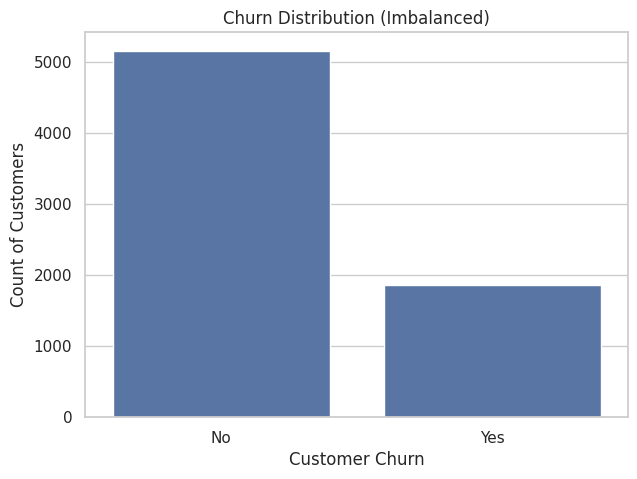


Conclusion: The dataset is 'imbalanced'.
The 'Yes' (Churn) class is the minority, which we must fix.


In [3]:
# Cell 3: Analyze Target Variable (Imbalance)
if df is not None:
    print("\n--- Phase 2: Exploratory Data Analysis (EDA) ---")

    # --- Step 1: Prove the Imbalance ---
    print("--- Churn Distribution Summary ---")
    # .value_counts() to see the split, turn yes/no into % use normalize
    print(df['Churn'].value_counts(normalize=True))

    # --- Step 2: Plot the Imbalance ---
    print("\nPlotting Churn Imbalance...")
    plt.figure(figsize=(7, 5))
    # We use a 'countplot' for a categorical (Yes/No) target
    sns.countplot(data=df, x='Churn')
    plt.title('Churn Distribution (Imbalanced)')
    plt.xlabel('Customer Churn')
    plt.ylabel('Count of Customers')
    plt.show()

    print("\nConclusion: The dataset is 'imbalanced'.")
    print("The 'Yes' (Churn) class is the minority, which we must fix.")
else:
    print("DataFrame `df` is not loaded. Skipping Cell 3.")


--- Analyzing Key Features vs. Churn ---


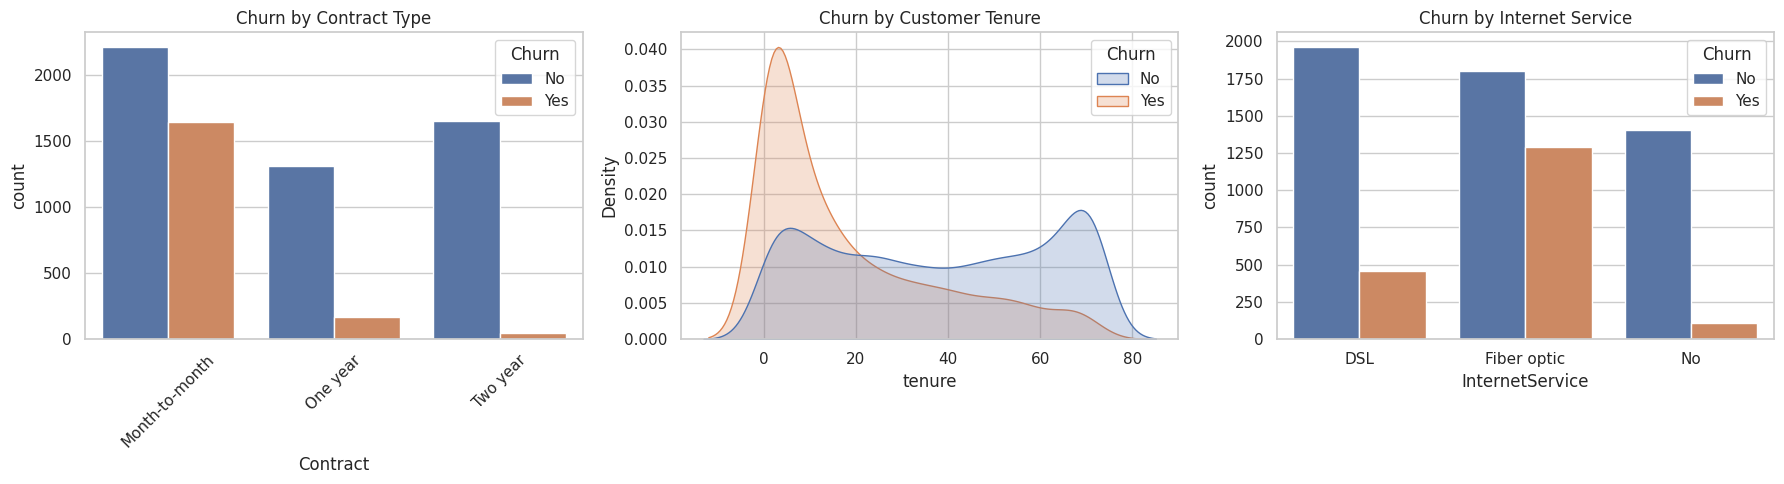

In [4]:
# Cell 4: Analyze Key Features
if df is not None:
    print("\n--- Analyzing Key Features vs. Churn ---")

    plt.figure(figsize=(18, 5))

    # Plot 1: Contract type vs. Churn
    # This is usually the strongest predictor.
    plt.subplot(1, 3, 1)
    sns.countplot(data=df, x='Contract', hue='Churn')
    plt.title('Churn by Contract Type')
    plt.xticks(rotation=45)

    # Plot 2: Tenure (how long they are a customer) vs. Churn
    plt.subplot(1, 3, 2)
    # A histogram (kde plot) is good for a numeric feature
    sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, common_norm=False)
    plt.title('Churn by Customer Tenure')

    # Plot 3: Internet Service vs. Churn
    plt.subplot(1, 3, 3)
    sns.countplot(data=df, x='InternetService', hue='Churn')
    plt.title('Churn by Internet Service')

    plt.tight_layout()
    plt.show()
else:
    print("DataFrame `df` is not loaded. Skipping Cell 4.")

In [5]:
# Cell 5: Split, Pre-process, and Manage Imbalance (SMOTE)
if df is not None:
    print("\n--- Phase 3: Final Prep, Split, & Imbalance Handling ---")

    # --- Step 1: Define Features (X) and Target (y) ---

    # First, convert our Yes/No target into 1s and 0s
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    target = 'Churn'

    # Get all column names EXCEPT our target
    features = df.columns.drop(target)

    # Find which features are numeric and which are categorical (text)
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
    categorical_features = df[features].select_dtypes(include='object').columns.tolist()

    X = df[features]
    y = df[target]

    print(f"Numeric features: {numeric_features}")
    print(f"Categorical features: {categorical_features}")

    # --- Step 2: Train-Test Split ---
    # We split 80/20. We keep X_test and y_test separate as our "final exam".
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nTraining set has {X_train.shape[0]} samples. Test set has {X_test.shape[0]} samples.")

    # --- Step 3: Build Pre-processing Pipeline ---
    # Same as regression: Scale numbers, One-Hot-Encode text.
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # --- Step 4: Fit and Transform the Data ---
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    print("Data processed (scaled and encoded).")

    # --- Step 5: **MANAGE IMBALANCE (SMOTE)** ---
    # This is a key requirement.
    # We apply SMOTE *only* to our training data.
    # It "over-samples" the minority class (Churn=Yes) by creating new,
    # synthetic (fake) examples, so our model has a 50/50 split to learn from.
    print("\nManaging imbalance with SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

    print(f"Original training shape: {y_train.shape[0]} samples")
    print(f"New 'resampled' training shape: {y_train_resampled.shape[0]} samples")
    print("Imbalance fixed for training.")

else:
    print("DataFrame `df` is not loaded. Skipping Cell 5.")


--- Phase 3: Final Prep, Split, & Imbalance Handling ---
Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Training set has 5616 samples. Test set has 1405 samples.
Data processed (scaled and encoded).

Managing imbalance with SMOTE...
Original training shape: 5616 samples
New 'resampled' training shape: 8222 samples
Imbalance fixed for training.


In [6]:
# Cell 6: NEW Evaluation Function
results = {} # main "Grade Book"

def evaluate_model(y_true, y_pred, model_name):
    """Calculates and prints classification metrics."""

    # 1. Calculate scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # 2. Print scores
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f} (How many it got right overall)")
    print(f"Precision: {precision:.4f} (Of the 'Yes' predictions, how many were right)")
    print(f"Recall: {recall:.4f} (Of all *actual* 'Yes' cases, how many did it find)")
    print(f"F1-Score: {f1:.4f} (A balanced score of Precision and Recall)")

    # 3. Print Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # 4. Return scores to save in our "Grade Book"
    return {'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

print("Evaluation function 'evaluate_model' defined.")

Evaluation function 'evaluate_model' defined.


In [7]:
# Cell 7: Model 1 (Traditional ML - Logistic Regression)
if 'X_train_resampled' in locals():
    print("\n--- Phase 4: Model Implementation ---")
    print("\nTraining Model 1: Logistic Regression (Base)...")

    # 1. Create the model
    # We add 'max_iter=1000' to help the model converge (find a solution)
    lr_model = LogisticRegression(random_state=42, max_iter=1000)

    # 2. Train the model on the **RESAMPLED** (balanced) data
    lr_model.fit(X_train_resampled, y_train_resampled)

    # 3. Make predictions on the original (unseen) test set
    y_pred_lr = lr_model.predict(X_test_processed)

    # 4. Grade the model using our new tool
    results['LR_Base'] = evaluate_model(y_test, y_pred_lr, "Logistic Regression (Base)")
else:
    print("Resampled data not found. Skipping Cell 7.")


--- Phase 4: Model Implementation ---

Training Model 1: Logistic Regression (Base)...

--- Logistic Regression (Base) Results ---
Accuracy: 0.7466 (How many it got right overall)
Precision: 0.4964 (Of the 'Yes' predictions, how many were right)
Recall: 0.7926 (Of all *actual* 'Yes' cases, how many did it find)
F1-Score: 0.6105 (A balanced score of Precision and Recall)

--- Confusion Matrix ---
[[770 283]
 [ 73 279]]


In [8]:
# Cell 8 Model 2 (Deep Learning - Base)
if 'X_train_resampled' in locals():
    print("\nTraining Model 2: Deep Learning (Base)...")

    # 1. Prepare data
    # are ALREADY dense numpy arrays.just remove .toarray()
    X_train_dense = X_train_resampled  # It's already dense
    X_test_dense = X_test_processed    # It's also already dense

    input_shape = X_train_dense.shape[1]
    print(f"Input shape for DL model: {input_shape} columns")

    # 2. Build the model blueprint
    dl_model = Sequential([
        Dense(32, activation='relu', input_shape=[input_shape]),
        Dense(16, activation='relu'),
        # CRITICAL: 1 output neuron with 'sigmoid' activation.
        # This outputs a probability (0.0 to 1.0) of Churn.
        Dense(1, activation='sigmoid')
    ])

    # 3. Compile the model
    # CRITICAL: We use 'binary_crossentropy' for a Yes/No problem.
    dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(dl_model.summary())

    # 4. Train the model on the **RESAMPLED** data
    dl_model.fit(
        X_train_dense, # Pass the corrected variable
        y_train_resampled,
        epochs=50,
        batch_size=32,
        verbose=0       # Hide the long training log
    )
    print("DL (Base) model training finished.")

    # 5. Make predictions
    # The model outputs probabilities
    y_pred_proba_dl = dl_model.predict(X_test_dense)
    # convert probabilities to 0s and 1s using a 0.5 threshold.
    y_pred_dl = (y_pred_proba_dl > 0.5).astype(int)

    # 6. Grade the model
    results['DL_Base'] = evaluate_model(y_test, y_pred_dl.flatten(), "Deep Learning (Base)")
else:
    print("Resampled data not found. Skipping Cell 8.")


Training Model 2: Deep Learning (Base)...
Input shape for DL model: 45 columns


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017 (7.88 KB)

 Trainable params: 2,017 (7.88 KB)

 Non-trainable params: 0 (0.00 B)

None
DL (Base) model training finished.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Deep Learning (Base) Results ---
Accuracy: 0.7374 (How many it got right overall)
Precision: 0.4823 (Of the 'Yes' predictions, how many were right)
Recall: 0.6562 (Of all *actual* 'Yes' cases, how many did it find)
F1-Score: 0.5560 (A balanced score of Precision and Recall)

--- Confusion Matrix ---
[[805 248]
 [121 231]]


In [10]:
# Cell 9:Model Tuning (Logistic Regression)
if 'X_train_resampled' in locals():
    print("\n--- Phase 5: Model Tuning & Optimization ---")
    print("\nTuning Model 1: Logistic Regression...")

    # 1. Create a "menu" of settings to try
    # 'C' is the regularization strength. 'solver' is the algorithm.
    param_dist = {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear', 'saga']
    }

    # 2. Set up the "Random Search" tool
    lr_random = RandomizedSearchCV(
        estimator=LogisticRegression(random_state=42, max_iter=1000),
        param_distributions=param_dist,
        n_iter=4,      # Try 4 random combinations (fast)
        cv=3,
        random_state=42,
        n_jobs=-1
    )

    # 3. Start the search (on resampled data)
    lr_random.fit(X_train_resampled, y_train_resampled)
    print(f"\nBest LR Params found: {lr_random.best_params_}")

    # 4. Make predictions with the BEST model
    y_pred_lr_tuned = lr_random.predict(X_test_processed)

    # 5. Grade the new tuned model
    results['LR_Tuned'] = evaluate_model(y_test, y_pred_lr_tuned, "Logistic Regression (Tuned)")
else:
    print("Resampled data not found. Skipping Cell 9.")


--- Phase 5: Model Tuning & Optimization ---

Tuning Model 1: Logistic Regression...

Best LR Params found: {'solver': 'saga', 'C': 10.0}

--- Logistic Regression (Tuned) Results ---
Accuracy: 0.7459 (How many it got right overall)
Precision: 0.4956 (Of the 'Yes' predictions, how many were right)
Recall: 0.7926 (Of all *actual* 'Yes' cases, how many did it find)
F1-Score: 0.6098 (A balanced score of Precision and Recall)

--- Confusion Matrix ---
[[769 284]
 [ 73 279]]


In [12]:
# Cell 10 Model Tuning (Deep Learning)
if 'X_train_resampled' in locals():
    print("\nTuning Model 2: Deep Learning (Manual)...")

    X_train_dense = X_train_resampled  # It's already dense
    X_test_dense = X_test_processed    # It's also already dense
    input_shape = X_train_dense.shape[1]

    print("Build a bigger model")

    # 1. Build a BIGGER model blueprint
    # Base model was 32 -> 16. Tuned model is 64 -> 32 -> 16
    dl_model_tuned = Sequential([
        Dense(64, activation='relu', input_shape=[input_shape]), # Bigger layer
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid') # Output still 1
    ])

    # 2. Compile
    dl_model_tuned.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(dl_model_tuned.summary())

    # 3. Train (on resampled data)
    dl_model_tuned.fit(
        X_train_dense, # Pass the corrected variable
        y_train_resampled,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    print("DL (Tuned) model training finished.")

    # 4. Predict and convert probabilities
    y_pred_proba_dl_tuned = dl_model_tuned.predict(X_test_dense)
    y_pred_dl_tuned = (y_pred_proba_dl_tuned > 0.5).astype(int)

    # 5. Grade
    results['DL_Tuned'] = evaluate_model(y_test, y_pred_dl_tuned.flatten(), "Deep Learning (Tuned)")
else:
    print("Resampled data not found. Skipping Cell 10.")


Tuning Model 2: Deep Learning (Manual)...
Build a bigger model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

None
DL (Tuned) model training finished.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Deep Learning (Tuned) Results ---
Accuracy: 0.7516 (How many it got right overall)
Precision: 0.5034 (Of the 'Yes' predictions, how many were right)
Recall: 0.6307 (Of all *actual* 'Yes' cases, how many did it find)
F1-Score: 0.5599 (A balanced score of Precision and Recall)

--- Confusion Matrix ---
[[834 219]
 [130 222]]


In [13]:
# Cell 11: Final Model Comparison
if results:
    print("\n\n--- Final Model Comparison ---")

    results_df = pd.DataFrame(results.values())
    results_df.set_index('Model', inplace=True)

    # Sort the table by 'F1-Score' (a good balanced metric), best to worst
    results_df.sort_values(by='F1', ascending=False, inplace=True)

    # Print the final, formatted table
    print(results_df.to_string(float_format="{:,.4f}".format))
else:
    print("No results to display. Please run the model cells.")



--- Final Model Comparison ---
                             Accuracy  Precision  Recall     F1
Model                                                          
Logistic Regression (Base)     0.7466     0.4964  0.7926 0.6105
Logistic Regression (Tuned)    0.7459     0.4956  0.7926 0.6098
Deep Learning (Tuned)          0.7516     0.5034  0.6307 0.5599
Deep Learning (Base)           0.7374     0.4823  0.6562 0.5560
